Cluster molecules and prioritize series from a high throughput screen.

Structure/activity data drawn from "A High Throughput Confirmatory Assay used to Identify Novel Compounds that Inhibit Mycobacterium Tuberculosis in the absence of Glycerol" (PubChem AID 449764).
https://pubchem.ncbi.nlm.nih.gov/bioassay/449764

Molecular descriptors calculated with KNIME-CDK version 1.5.600.v201711101057.

In [1]:
## setup cell
# chemistry functions
from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

# other libraries
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
## load and process data
# load the initial dataset
screening_data = pd.read_csv("data/descriptors.csv")

# generate pIC90 for plotting; add placeholder value of 1 for inactive compounds
screening_data["pIC90"] = screening_data["IC90"].apply(lambda x: -1 * np.log10(x * 1e-6))
screening_data["pIC90"][screening_data["IC90"].isna()] = 1

# bin pIC90 for plotting
screening_data["activity levels"] = pd.cut(screening_data["pIC90"], bins = [0, 2, 4, 5, 100], labels = ["inactive", "low", "medium", "high"])

# generate pIC50 for plotting; add placeholder value of 1 for inactive compounds
screening_data["pIC50"] = screening_data["IC50"].apply(lambda x: -1 * np.log10(x * 1e-6))
screening_data["pIC50"][screening_data["IC50"].isna()] = 1

# bin pIC50 for plotting
screening_data["cytotoxicity"] = pd.cut(screening_data["pIC50"], bins = [0, 2, 4, 5, 100], labels = ["inactive", "low", "medium", "high"])

# convert SMILES strings into RDKit format
screening_data["mol"] = screening_data["SMILES"].apply(Chem.MolFromSmiles)

# calculate Morgan fingerprints for the molecules
screening_data["fingerprints"] = screening_data["mol"].apply(lambda x: GetMorganFingerprintAsBitVect(x, 2))

In [3]:
## calculate Tanimoto distance matrix between molecular fingerprints
# declare an array to hold the distances
distances = np.empty([len(screening_data["fingerprints"]), len(screening_data["fingerprints"])])

# calculate the distance array
for i in range(len(screening_data["fingerprints"])):
    for j in range(i, len(screening_data["fingerprints"])):
        distances[i, j] = 1 - DataStructs.TanimotoSimilarity(screening_data["fingerprints"][i], screening_data["fingerprints"][j])
        distances[j, i] = distances[i, j]
        
# flatten the distance array into a list as required by the clustering algorithm
# declare an empty list to hold the distances
distances_list = []

# iterate through the matrix row by row, taking just the diagonal and top half
for i in range(np.shape(distances)[0]):
    for j in range(i, np.shape(distances)[1]):
        distances_list.append(distances[i, j])

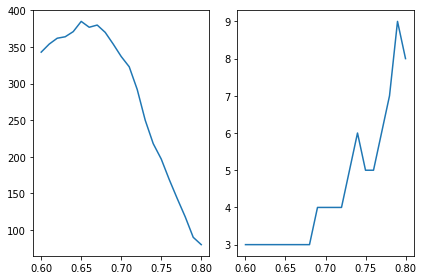

In [4]:
## tune clustering algorithm
# select some threshold values to try
epsilon = np.arange(0.6, 0.8, 0.01)

# declare an empty array to hold the number of clusters and median cluster size
n_clusters = np.empty([len(epsilon), 2])

# scan through threshold values
for i in range(len(epsilon)):
    # cluster by distance at each epsilon
    clusters = Butina.ClusterData(distances_list, nPts = np.shape(screening_data)[0], distThresh = epsilon[i], isDistData = True)
    
    # store the number of clusters generated and median cluster size
    # number of clusters (excluding singletons)
    n_clusters[i, 0] = len([len(cluster) for cluster in clusters if len(cluster) > 1])
    n_clusters[i, 1] = np.median([len(cluster) for cluster in clusters if len(cluster) > 1])
    
# plot number of clusters as a function of epsilon
fig, axs = plt.subplots(1, 2, tight_layout = True)
axs[0].plot(epsilon, n_clusters[:, 0])
axs[1].plot(epsilon, n_clusters[:, 1])
plt.show()

In [5]:
## cluster compounds
# cluster compounds to give a balance between number of clusters and cluster size
clusters = Butina.ClusterData(distances_list, nPts = np.shape(screening_data)[0], distThresh = 0.74, isDistData = True)

# store the cluster assignments back in the screening data dataframe
for cluster in range(len(clusters)):
    for compound in clusters[cluster]:
        screening_data.loc[compound, "cluster"] = cluster

In [6]:
# identify clusters with ten or more members
major_clusters = [group for group in screening_data.groupby("cluster").groups if len(screening_data.groupby("cluster").groups[group]) >= 10]

# subset the data to just the major clusters
clustered_data = screening_data.query("cluster in @major_clusters")

# number of major clusters
len(major_clusters)

68

We have identified 68 clusters of reasonable size. The next step will be to prioritize the clustered compounds for future development. We will start by filtering down to clusters with good separation between activity and cytotoxicity.

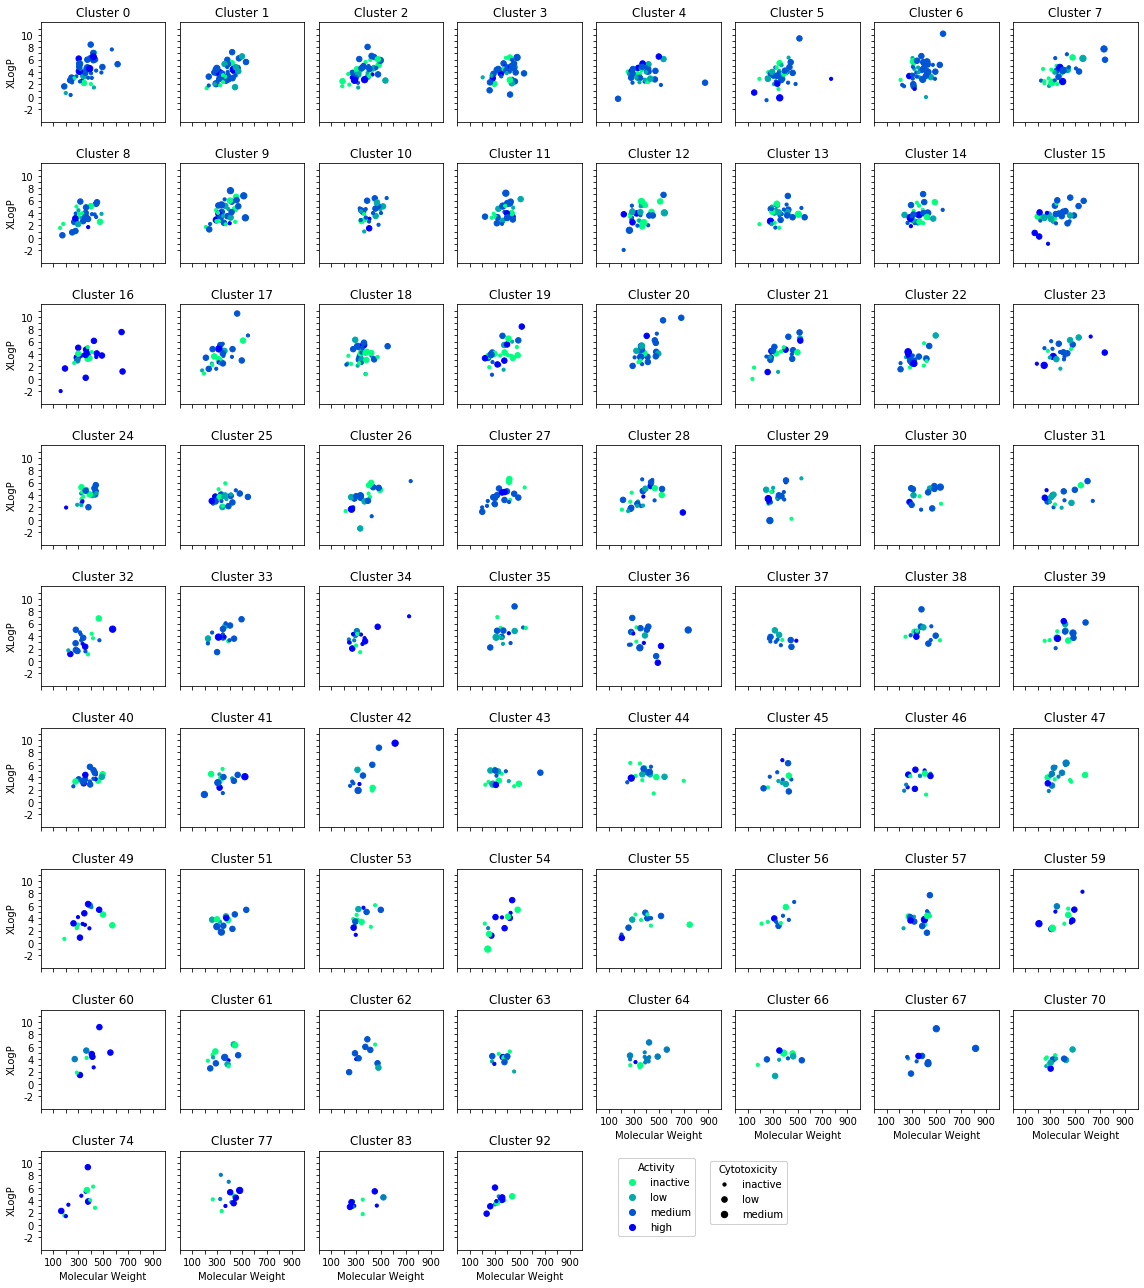

In [129]:
## plot clusters independently
# create a grid of axes
fig, axs = plt.subplots(9, 8, tight_layout = True, figsize = (16, 18))

# hide the empty subplots
axs[-1, -1].axis("off")
axs[-1, -2].axis("off")
axs[-1, -3].axis("off")
axs[-1, -4].axis("off")

# add a scatterplot for each cluster
for i in range(len(clustered_data["cluster"].unique())):
    
    # subset the clustered dataset to the current cluster
    cluster_data = clustered_data[clustered_data["cluster"] == np.sort(clustered_data["cluster"].unique())[i]]
    
    # add a scatterplot for the current cluster
    axs.flat[i].scatter(cluster_data["Molecular Weight"], cluster_data["XLogP"], 
          c = cluster_data["activity levels"].cat.codes, s = (cluster_data["cytotoxicity"].cat.codes + 1) * 10, cmap = "winter_r")
    
    # add title to the subplot
    axs.flat[i].set_title("Cluster %s" %int(np.sort(clustered_data["cluster"].unique())[i]))
    
    # set scale and tick marks
    axs.flat[i].set_xlim([0, 1000])
    axs.flat[i].set_xticks([i * 100 for i in range(10)])
    axs.flat[i].set_xticklabels([])
    axs.flat[i].set_ylim([-4, 12])
    axs.flat[i].set_yticks([i for i in range(-2, 12)])
    axs.flat[i].set_yticklabels([])
    
# label axis on the outside of the plot
# x-axis
for i in axs[8, 0:4]:
    i.set_xlabel("Molecular Weight")
    i.set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
for i in axs[7, 4:8]:
    i.set_xlabel("Molecular Weight")
    i.set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
# y-axis
for i in axs[:, 0]:
    i.set_ylabel("XLogP")
    i.set_yticklabels([str(i) if i%2 == 0 else "" for i in range(-2, 12)])
    
# add legends for color and size
dummy = plt.scatter(clustered_data["Molecular Weight"], clustered_data["XLogP"], 
    c = clustered_data["activity levels"].cat.codes, s = (clustered_data["cytotoxicity"].cat.codes + 1) * 10, cmap = "winter_r")
color_legend = fig.legend(dummy.legend_elements(prop = "colors")[0], cluster_data["activity levels"].cat.categories, 
                          loc = [0.54, 0.04], title = "Activity")
fig.add_artist(color_legend)
size_legend = fig.legend(dummy.legend_elements(prop = "sizes")[0], cluster_data["cytotoxicity"].cat.categories, 
                         loc = [0.62, 0.05], title = "Cytotoxicity")
fig.add_artist(size_legend)
dummy.remove()

# display the figure
fig.show()

In [95]:
## calculate activity window for clustered compounds
# calculate activity window (-log10)
clustered_data = clustered_data.assign(pWindow = clustered_data["pIC90"] - clustered_data["pIC50"])

# calculate the median activity window for each cluster among active compounds
clustered_stats = clustered_data.query("pIC90 > 1").groupby("cluster").agg({"pWindow": "median"})

# calculate the fraction of active compounds in each cluster
clustered_stats["fractionActive"] = clustered_data.query("pIC90 > 2").groupby("cluster").agg({"row ID": "count"}) / clustered_data.groupby("cluster").agg({"row ID": "count"})

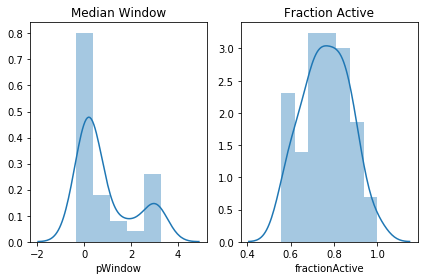

In [99]:
# histograms of median activity window and fraction active
fig, axs = plt.subplots(1, 2, tight_layout = True)

sns.distplot(clustered_stats["pWindow"], ax = axs[0])
axs[0].set_title("Median Window")

sns.distplot(clustered_stats["fractionActive"], ax = axs[1])
axs[1].set_title("Fraction Active")

fig.show()

Many of the clusters appear to have issues with cytotoxicity. All of them appear to have a reasonable number of active compounds to work with. Filtering out those without separation of activity and cytotoxicity.

In [100]:
# identify clusters with at least an order of magnitude in median activity window
top_clusters = clustered_stats.query("pWindow > 1").index

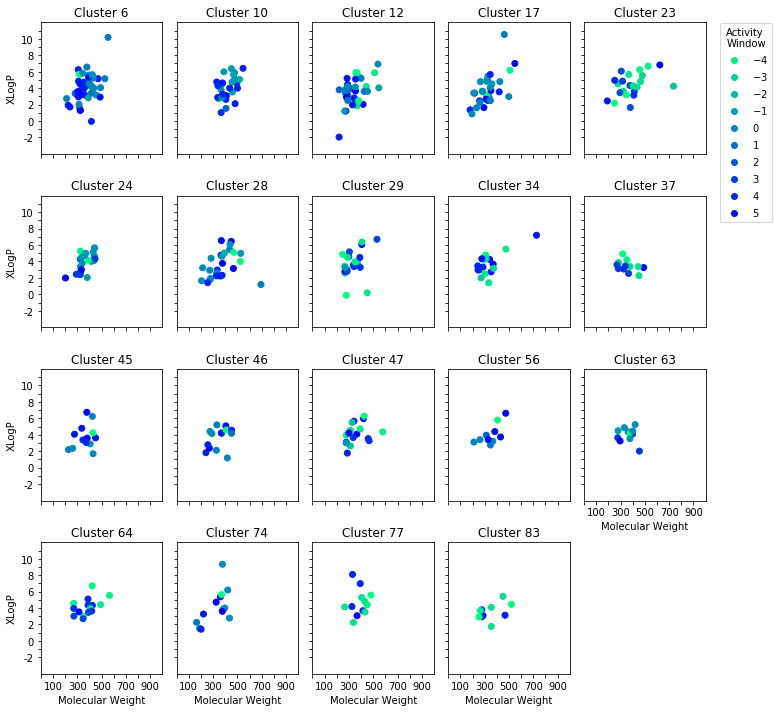

In [115]:
## plot clusters independently
# create a grid of axes
fig, axs = plt.subplots(4, 5, tight_layout = True, figsize = (10, 10))

# hide the empty subplots
axs[-1, -1].axis("off")

# add a scatterplot for each cluster
for i in range(len(top_clusters)):
    
    # subset the clustered dataset to the current cluster
    cluster_data = clustered_data[clustered_data["cluster"] == top_clusters[i]]
    
    # add a scatterplot for the current cluster
    axs.flat[i].scatter(cluster_data["Molecular Weight"], cluster_data["XLogP"], 
          c = cluster_data["pWindow"], cmap = "winter_r")
    
    # add title to the subplot
    axs.flat[i].set_title("Cluster %s" %int(top_clusters[i]))
    
    # set scale and tick marks
    axs.flat[i].set_xlim([0, 1000])
    axs.flat[i].set_xticks([i * 100 for i in range(10)])
    axs.flat[i].set_xticklabels([])
    axs.flat[i].set_ylim([-4, 12])
    axs.flat[i].set_yticks([i for i in range(-2, 12)])
    axs.flat[i].set_yticklabels([])
    
# label axis on the outside of the plot
# x-axis
for i in axs[3, 0:4]:
    i.set_xlabel("Molecular Weight")
    i.set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
axs[2, 4].set_xlabel("Molecular Weight")
axs[2, 4].set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
# y-axis
for i in axs[:, 0]:
    i.set_ylabel("XLogP")
    i.set_yticklabels([str(i) if i%2 == 0 else "" for i in range(-2, 12)])

# add legends for color and size
dummy = plt.scatter(clustered_data["Molecular Weight"], clustered_data["XLogP"], c = clustered_data["pWindow"], cmap = "winter_r")
color_legend = fig.legend(*dummy.legend_elements(prop = "colors"), loc = [0.85, 0.08], title = "Activity\nWindow", bbox_to_anchor = (1, 0.68))
dummy.remove()

# display the figure
fig.show()

Now that we are down to a handful of the most promising series in terms of activities, we will prioritize them by attractiveness of their chemical space.

In [201]:
## calculate correlations between several properties and tubercular activity to plot
# subset out active compounds in top clusters
top_actives = clustered_data[clustered_data["cluster"].isin(top_clusters)].query("pIC90 > 1")

# calculate correlation between key molecular properties and activities
top_actives_corr = top_actives[["cluster", "pIC90", "XLogP", "Topological Polar Surface Area", "Molecular Weight"]].groupby("cluster").corr()

# convert into a dataframe of clusters, properties, and correlations
top_actives_corr = pd.DataFrame(data = {"cluster": top_actives_corr["pIC90"].index.to_frame()["cluster"], "property": top_actives_corr["pIC90"].index.to_frame()[1],"correlation": top_actives_corr["pIC90"]})

# remove pIC90/pIC90 correlations
top_actives_corr = top_actives_corr.query("property != 'pIC90'")

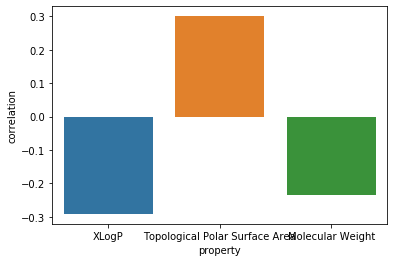

In [206]:
cluster_data = top_actives_corr[top_actives_corr["cluster"] == top_clusters[1]]
sns.barplot(x = "property", y = "correlation", data = cluster_data)

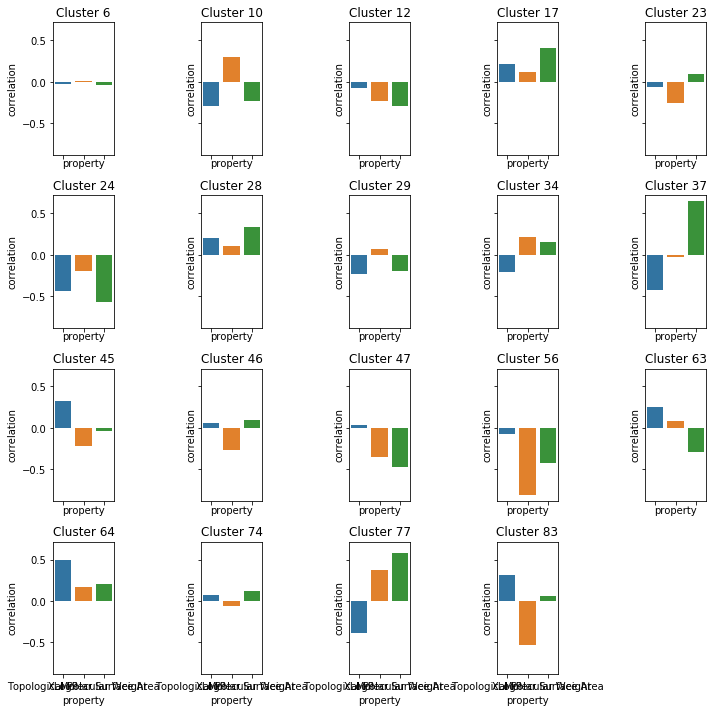

In [210]:
## plot clusters independently
# create a grid of axes
fig, axs = plt.subplots(4, 5, sharex = True, sharey = True, tight_layout = True, figsize = (10, 10))

# hide the empty subplots
axs[-1, -1].axis("off")

# add a bar plot for each cluster
for i in range(len(top_clusters)):
    
    # subset the clustered dataset to the current cluster
    cluster_data = top_actives_corr[top_actives_corr["cluster"] == top_clusters[i]]
    
    # add a bar plot of correlations for the current cluster
    sns.barplot(x = "property", y = "correlation", data = cluster_data, ax = axs.flat[i])
    
    # add title to the subplot
    axs.flat[i].set_title("Cluster %s" %int(top_clusters[i]))
    
# label axis on the outside of the plot
# x-axis
#for i in axs[3, 0:4]:
#    i.set_xlabel("Molecular Weight")
#    i.set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
#axs[2, 4].set_xlabel("Molecular Weight")
#axs[2, 4].set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
# y-axis
#for i in axs[:, 0]:
#    i.set_ylabel("XLogP")
#    i.set_yticklabels([str(i) if i%2 == 0 else "" for i in range(-2, 12)])

# display the figure
fig.show()

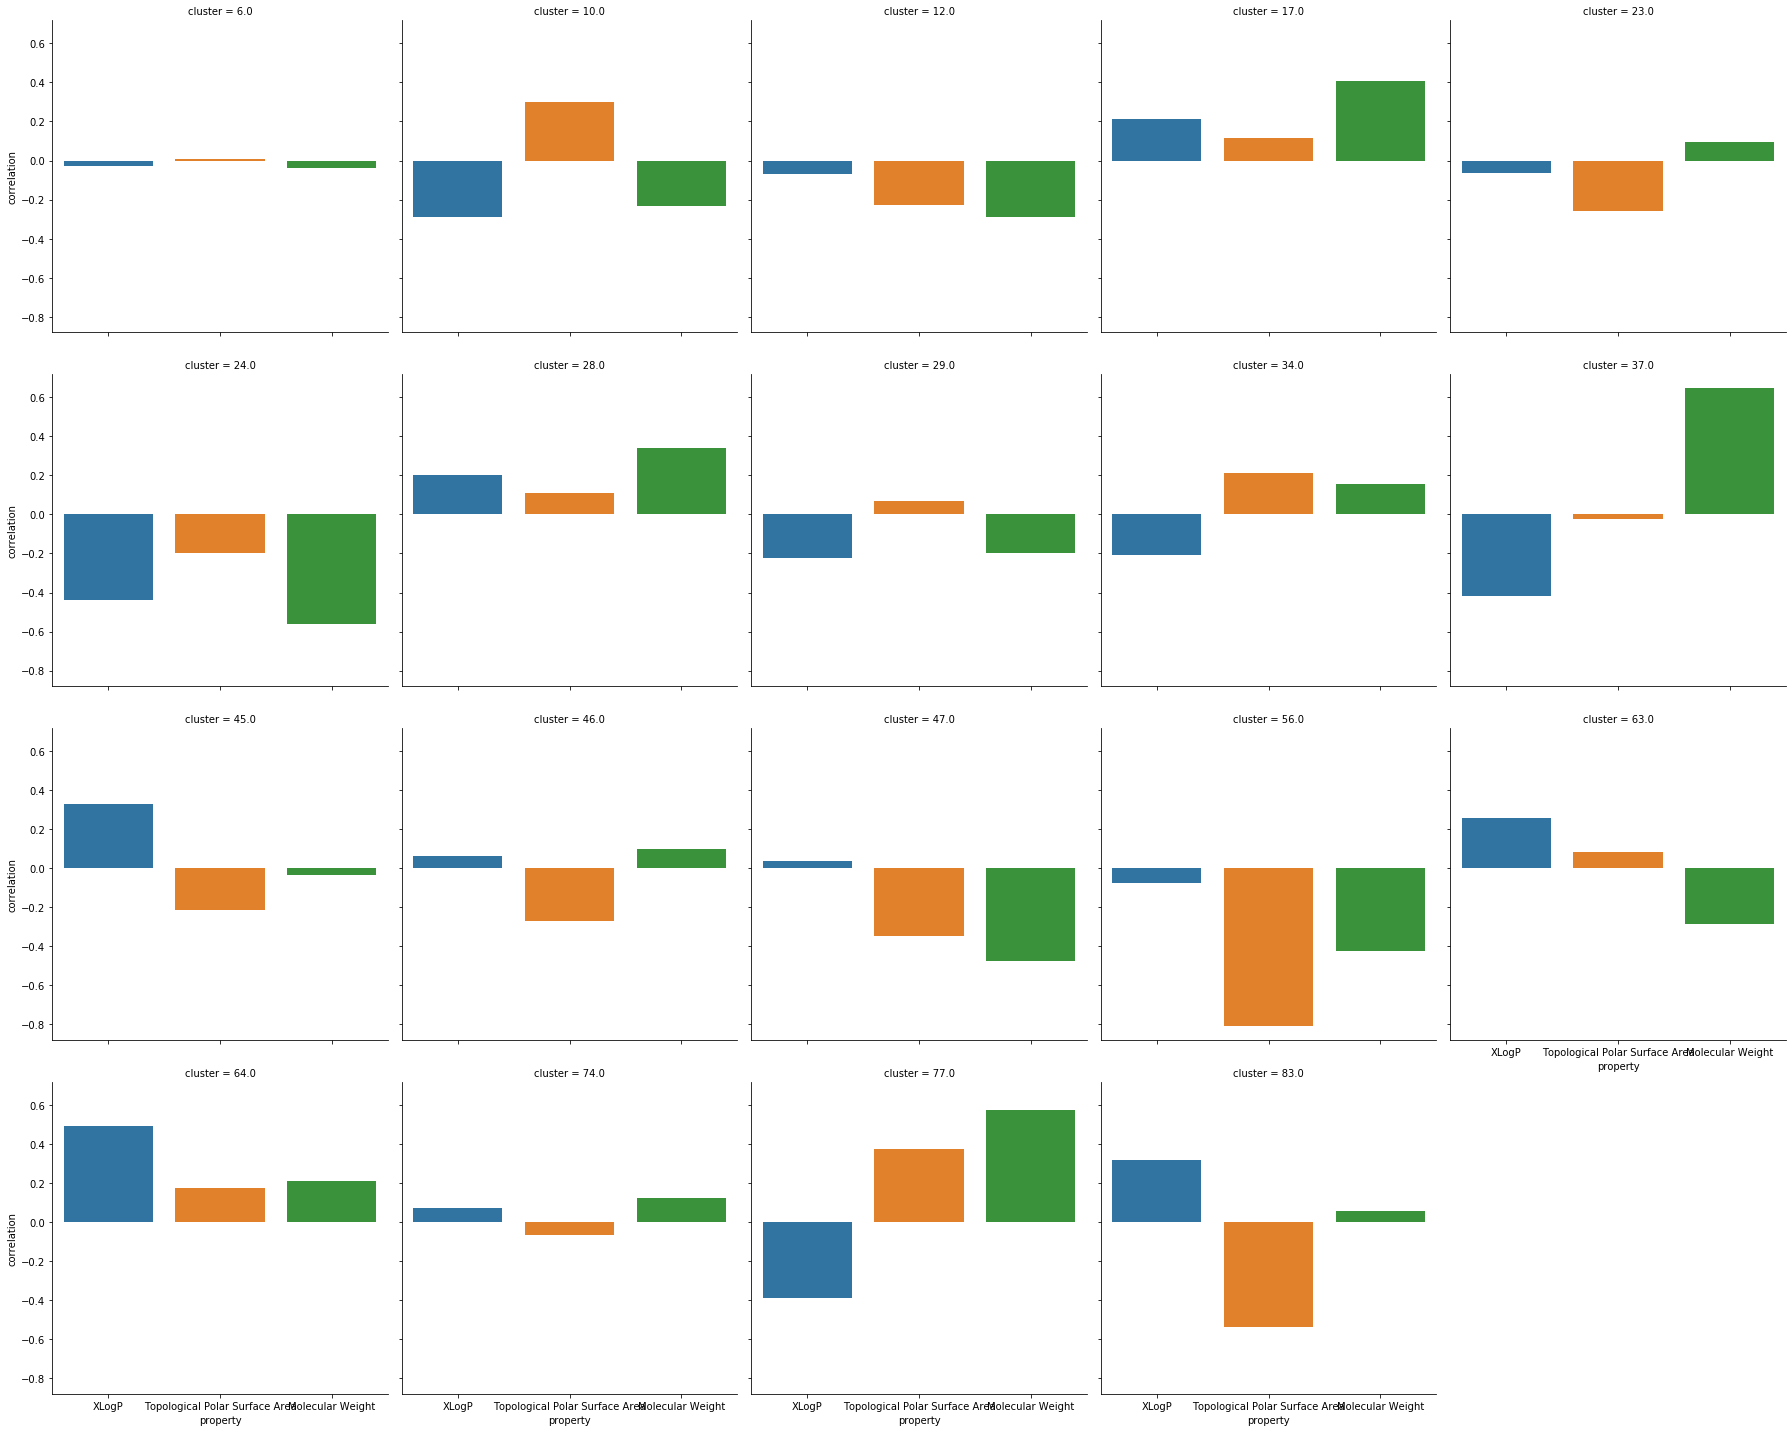

In [216]:
# generate bar plots for each cluster
fig = sns.catplot(x = "property", y = "correlation", col = "cluster", col_wrap = 5, data = top_actives_corr, kind = "bar")
